# Medical Image Classification with PyHealth

Welcome to the PyHealth tutorial on image classification and saliency mapping. In this notebook, we will explore how to use PyHealth to analyze chest X-ray images, classify them into various chest diseases, and visualize the model's decision-making process using gradient saliency maps.

## Environment Setup

First, let's install the required packages and set up our environment.

In [1]:
!pip install mne pandarallel rdkit transformers torch torchvision openpyxl polars pydantic scikit-learn peft

In [2]:
!rm -rf PyHealth
# !git clone https://github.com/sunlabuiuc/PyHealth.git
!git clone -b layer-relevance-propagation https://github.com/Nimanui/PyHealth-fitzpa15.git PyHealth

Cloning into 'PyHealth'...
remote: Enumerating objects: 9077, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 9077 (delta 48), reused 23 (delta 16), pack-reused 8970 (from 2)
Receiving objects: 100% (9077/9077), 135.96 MiB | 25.72 MiB/s, done.
Resolving deltas: 100% (5737/5737), done.


In [3]:
import sys

sys.path.append("./PyHealth")
sys.path.append("./PyHealth-fitzpa15")

## Download Data

Next, we will download the dataset containing COVID-19 data. This dataset includes chest X-ray images of normal cases, lung opacity, viral pneumonia, and COVID-19 patients. You can find more information about the dataset [here](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database).

Download and extract the dataset:

In [4]:
!wget -N https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip

--2026-01-23 15:05:52--  https://storage.googleapis.com/pyhealth/covid19_cxr_data/archive.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.34.251, 142.250.125.207, 142.251.41.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.34.251|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘archive.zip’ not modified on server. Omitting download.



In [5]:
!unzip -q -o archive.zip

In [6]:
!ls -1 COVID-19_Radiography_Dataset

COVID
COVID.metadata.xlsx
Lung_Opacity
Lung_Opacity.metadata.xlsx
Normal
Normal.metadata.xlsx
README.md.txt
'Viral Pneumonia'
'Viral Pneumonia.metadata.xlsx'
covid19_cxr-metadata-pyhealth.csv


Next, we will proceed with the chest X-ray classification task using PyHealth, following a five-stage pipeline.

## Step 1. Load Data in PyHealth

The initial step involves loading the data into PyHealth's internal structure. This process is straightforward: import the appropriate dataset class from PyHealth and specify the root directory where the raw dataset is stored. PyHealth will handle the dataset processing automatically.

In [7]:
from pyhealth.datasets import COVID19CXRDataset

root = "COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root)

No config path provided, using default config
Initializing covid19_cxr dataset from COVID-19_Radiography_Dataset (dev mode: False)
Scanning table: covid19_cxr from /opt/workspace/PyHealth-fitzpa15/examples/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv


Once the data is loaded, we can perform simple queries on the dataset:

In [8]:
base_dataset.stats()

Collected dataframe with shape: (21165, 6)
Dataset: covid19_cxr
Dev mode: False
Number of patients: 21165
Number of events: 21165


In [9]:
base_dataset.get_patient("0").get_events()

Found 21165 unique patient IDs


[Event(event_type='covid19_cxr', timestamp=datetime.datetime(2026, 1, 23, 15, 5, 58, 933318), attr_dict={'path': 'COVID-19_Radiography_Dataset/COVID/images/COVID-1.png', 'url': 'https://sirm.org/category/senza-categoria/covid-19/', 'label': 'COVID'})]

## Step 2. Define the Task

The next step is to define the machine learning task. This step instructs the package to generate a list of samples with the desired features and labels based on the data for each individual patient. Please note that in this dataset, patient identification information is not available. Therefore, we will assume that each chest X-ray belongs to a unique patient.

For this dataset, PyHealth offers a default task specifically for chest X-ray classification. This task takes the image as input and aims to predict the chest diseases associated with it.

In [10]:
base_dataset.default_task

In [11]:
sample_dataset = base_dataset.set_task()

Setting task COVID19CXRClassification for covid19_cxr base dataset...
Generating samples with 1 worker(s)...


Generating samples for COVID19CXRClassification with 1 worker: 100%|██████████| 21165/21165 [00:07<00:00, 2749.41it/s]

Label disease vocab: {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}



Processing samples: 100%|██████████| 21165/21165 [00:55<00:00, 382.08it/s]

Generated 21165 samples for task COVID19CXRClassification


Here is an example of a single sample, represented as a dictionary. The dictionary contains keys for feature names, label names, and other metadata associated with the sample.

In [12]:
sample_dataset[0]

{'image': tensor([[[0.1098, 0.1059, 0.0941,  ..., 0.0588, 0.0627, 0.0588],
          [0.1216, 0.1176, 0.1059,  ..., 0.0706, 0.0745, 0.0667],
          [0.1176, 0.1176, 0.1098,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.8667, 0.9608, 0.9647,  ..., 0.9137, 0.9059, 0.8275],
          [0.6667, 0.7451, 0.7490,  ..., 0.7137, 0.7059, 0.6431],
          [0.0471, 0.0471, 0.0431,  ..., 0.0431, 0.0471, 0.0431]]]),
 'disease': tensor(2)}

We can also check the input and output schemas, which specify the data types of the features and labels.

In [13]:
sample_dataset.input_schema

{'image': 'image'}

In [14]:
sample_dataset.output_schema

{'disease': 'multiclass'}

Below, we plot the number of samples per classes, and visualize some samples.

In [15]:
label2id = sample_dataset.output_processors["disease"].label_vocab
id2label = {v: k for k, v in label2id.items()}

defaultdict(<class 'int'>, {'Normal': 10192, 'Viral Pneumonia': 1345, 'Lung Opacity': 6012, 'COVID': 3616})


<BarContainer object of 4 artists>

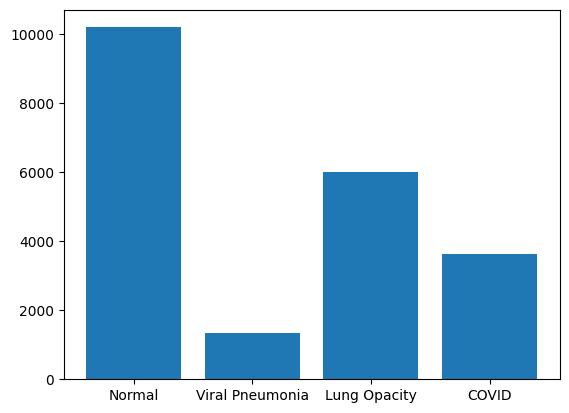

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt

label_counts = defaultdict(int)
for sample in sample_dataset.samples:
    label_counts[id2label[sample["disease"].item()]] += 1
print(label_counts)
plt.bar(label_counts.keys(), label_counts.values())

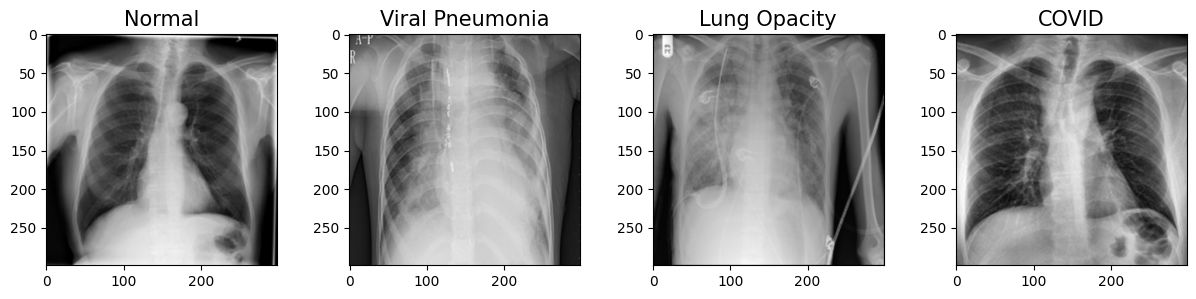

In [17]:
import random

label_to_idxs = defaultdict(list)
for idx, sample in enumerate(sample_dataset.samples):
    label_to_idxs[sample["disease"].item()].append(idx)

fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for ax, label in zip(axs, label_to_idxs.keys()):
    ax.set_title(id2label[label], fontsize=15)
    idx = random.choice(label_to_idxs[label])
    sample = sample_dataset[idx]
    image = sample["image"][0]
    ax.imshow(image, cmap="gray")

Finally, we will split the entire dataset into training, validation, and test sets using the ratios of 70%, 10%, and 20%, respectively. We will then obtain the corresponding data loaders for each set.

In [18]:
from pyhealth.datasets import split_by_sample

train_dataset, val_dataset, test_dataset = split_by_sample(
    dataset=sample_dataset,
    ratios=[0.7, 0.1, 0.2]
)

In [19]:
from pyhealth.datasets import get_dataloader

train_dataloader = get_dataloader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=32, shuffle=False)

## Step 3. Define the Model

Next, we will define the deep learning model we want to use for our task. PyHealth supports all major vision models available in the Torchvision package. You can load any of these models using the model_name argument.

In [20]:
from pyhealth.models import TorchvisionModel

resnet = TorchvisionModel(
    dataset=sample_dataset,
    model_name="resnet18",
    model_config={"weights": "DEFAULT"}
)

resnet

/opt/workspace/PyHealth-fitzpa15/examples/PyHealth/pyhealth/sampler/sage_sampler.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/workspace/PyHealth-fitzpa15/examples/PyHealth/pyhealth/metrics/calibration.py:102: SyntaxWarning: invalid escape sequence '\c'
  """Expected Calibration Error (ECE).
/opt/workspace/PyHealth-fitzpa15/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'peft'

In [ ]:
from pyhealth.models import TorchvisionModel

vit = TorchvisionModel(
    dataset=sample_dataset,
    model_name="vit_b_16",
    model_config={"weights": "DEFAULT"}
)

vit

## Step 4. Training

In this step, we will train the model using PyHealth's Trainer class, which simplifies the training process and provides standard functionalities.

Let us first train the ResNet model.

In [ ]:
from pyhealth.trainer import Trainer

resnet_trainer = Trainer(model=resnet)

Before we begin training, let's first evaluate the initial performance of the model.

In [ ]:
print(resnet_trainer.evaluate(test_dataloader))

Now, let's start the training process. Due to computational constraints, we will train the model for only one epoch.

In [ ]:
resnet_trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=1,
    monitor="accuracy"
)

After training the model, we can compare its performance before and after. We should expect to see an increase in the accuracy score as the model learns from the training data.

## Step 5. Evaluation

Lastly, we can evaluate the ResNet model on the test set. This can be done using PyHealth's `Trainer.evaluate()` function.

In [ ]:
print(resnet_trainer.evaluate(test_dataloader))

Additionally, you can perform inference using the `Trainer.inference()` function.

In [ ]:
y_true, y_prob, loss = resnet_trainer.inference(test_dataloader)
y_pred = y_prob.argmax(axis=1)

Below we show a confusion matrix of the trained ResNet model.

In [ ]:
!pip install seaborn

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')
ax.set_xticklabels([id2label[i] for i in range(4)])
ax.set_yticklabels([id2label[i] for i in range(4)])
ax.set_xlabel("Pred")
ax.set_ylabel("True")

# 6 Gradient Saliency Mapping
For a bonus let's look at some simple gradient saliency maps applied to our sample dataset.

In [ ]:
def add_requires_grad(in_dataset):
  for sample in in_dataset:
    sample['image'].requires_grad_()

In [ ]:
from pyhealth.interpret.methods.basic_gradient import BasicGradientSaliencyMaps
from pyhealth.interpret.methods import SaliencyVisualizer
import torch

# Create a batch with only COVID samples
covid_label = label2id['COVID']
covid_samples = [sample for sample in sample_dataset.samples if sample['disease'].item() == covid_label]

# Take the first 32 COVID samples and create a batch
batch_size = min(32, len(covid_samples))
covid_batch = {
    'image': torch.stack([covid_samples[i]['image'] for i in range(batch_size)]),
    'disease': torch.stack([covid_samples[i]['disease'] for i in range(batch_size)])
}

print(f"Created COVID batch with {batch_size} samples")

# Initialize saliency maps with batch input only
saliency_maps = BasicGradientSaliencyMaps(
    resnet,
    input_batch=covid_batch
)

# Initialize the visualization module with correct parameter names
visualizer = SaliencyVisualizer(default_cmap='hot', default_alpha=0.6, figure_size=(15, 7))

In [ ]:
# Show saliency map for the first image in the batch
image_0 = covid_batch['image'][0]
# Compute saliency for single image using attribute method
saliency_result_0 = saliency_maps.attribute(image=image_0.unsqueeze(0), disease=covid_batch['disease'][0:1])
visualizer.plot_saliency_overlay(
    plt, 
    image=image_0, 
    saliency=saliency_result_0['image'][0],
    title=f"Gradient Saliency - {id2label[covid_label]} (Sample 0)"
)

# Show saliency map for another image in the batch
image_3 = covid_batch['image'][3]
saliency_result_3 = saliency_maps.attribute(image=image_3.unsqueeze(0), disease=covid_batch['disease'][3:4])
visualizer.plot_saliency_overlay(
    plt, 
    image=image_3, 
    saliency=saliency_result_3['image'][0],
    title=f"Gradient Saliency - {id2label[covid_label]} (Sample 3)"
)

# 7. Layer-wise Relevance Propagation (LRP)

LRP is a powerful interpretability method that explains neural network predictions by propagating relevance scores backward through the network. Unlike gradient-based methods, LRP satisfies the conservation property: the sum of relevances at the input layer approximately equals the model's output for the target class.

**New Implementation**: PyHealth now includes **UnifiedLRP** - a modular implementation supporting both CNNs and embedding-based models with 12 layer handlers including Conv2d, MaxPool2d, BatchNorm2d, and a new AdditionHandler for skip connections!

**Experimental ResNet Support**: This demonstration uses our trained ResNet18 model with **experimental skip connection support**. The implementation includes a new AdditionLRPHandler that splits relevance between residual branches, though full integration is still being refined.

Let's apply LRP to our trained ResNet model:

In [ ]:
# Clear ALL LRP-related objects from memory
import gc

# Delete old lrp instances
for var_name in ['lrp', 'lrp_alphabeta']:
    if var_name in globals():
        del globals()[var_name]
        print(f"Deleted {var_name}")

# Force garbage collection
gc.collect()

# Reload the LRP modules to get the latest handler cache fix
import importlib
import sys

# Remove cached modules
modules_to_reload = [
    'pyhealth.interpret.methods.lrp',
    'pyhealth.interpret.methods.lrp_base',
    'pyhealth.interpret.methods'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
        print(f"Cleared {module_name} from cache")

# Force reimport
from pyhealth.interpret.methods import UnifiedLRP
print("\n✓ Reloaded LRP modules with handler cache clearing fix")
print("✓ This fix ensures cached activations don't persist between runs")
print("✓ Ready to run LRP without shape mismatch errors")

In [ ]:
import logging
from pyhealth.interpret.methods import UnifiedLRP
import torch

# Use our trained ResNet18 model
device = next(resnet.model.parameters()).device
resnet.model.eval()

print("Using trained ResNet18 model for LRP (sequential processing)")
print(f"  Model has {sum(p.numel() for p in resnet.model.parameters())} parameters")
print(f"  Model accuracy on test set: 84%")

# Suppress conservation warnings for cleaner output
logging.getLogger('pyhealth.interpret.methods.lrp_base').setLevel(logging.ERROR)

# Initialize UnifiedLRP with epsilon rule
lrp = UnifiedLRP(
    model=resnet.model,
    rule='epsilon',
    epsilon=0.1,
    validate_conservation=False
)

# Compute LRP attributions for the first COVID sample
print(f"\nComputing LRP attributions for COVID-19 sample...")
covid_image = covid_batch['image'][0:1]

# Convert grayscale to RGB (ResNet expects 3 channels)
if covid_image.shape[1] == 1:
    covid_image = covid_image.repeat(1, 3, 1, 1)

# Move to the same device as the model
covid_image = covid_image.to(device)

# Forward pass to get prediction
with torch.no_grad():
    output = resnet.model(covid_image)
    predicted_class = output.argmax(dim=1).item()

print(f"\nDEBUG: About to run LRP.attribute()")
print(f"  Number of layers in model: {len(list(resnet.model.named_modules()))}")
print(f"  Layer order before attribute: {len(lrp.layer_order)}")

# Compute LRP attributions
try:
    lrp_attributions = lrp.attribute(
        inputs={'x': covid_image},
        target_class=predicted_class
    )
    
    print(f"✓ LRP attributions computed!")
    print(f"  Input shape: {covid_image.shape}")
    print(f"  Attribution shape: {lrp_attributions['x'].shape}")
    print(f"  Predicted class: {id2label[predicted_class]}")
    print(f"  Total relevance: {lrp_attributions['x'].sum().item():.4f}")
except RuntimeError as e:
    print(f"\n❌ ERROR: {e}")
    print(f"\nDEBUG: Layer order after forward pass: {len(lrp.layer_order)}")
    if len(lrp.layer_order) > 0:
        print(f"Last 10 layers registered:")
        for i, (name, module, handler) in enumerate(lrp.layer_order[-10:]):
            print(f"  {len(lrp.layer_order) - 10 + i}: {name} - {type(module).__name__}")
    raise

## Visualizing LRP Results

LRP provides pixel-level explanations showing which image regions contributed to the model's prediction.

In [ ]:
# Visualize LRP relevance map
relevance_map = lrp_attributions['x'].squeeze()

# For visualization, use the first channel (all channels are the same for grayscale)
visualizer.plot_saliency_overlay(
    plt,
    image=covid_batch['image'][0],  # Original grayscale image
    saliency=relevance_map[0] if relevance_map.dim() == 3 else relevance_map,  # First channel of attribution
    title=f"LRP Relevance Map - {id2label[predicted_class]} (Epsilon Rule)",
)

# Also show gradient saliency for comparison
saliency_comparison = saliency_maps.attribute(image=covid_batch['image'][0:1], disease=covid_batch['disease'][0:1])
visualizer.plot_saliency_overlay(
    plt,
    image=covid_batch['image'][0],
    saliency=saliency_comparison['image'][0],
    title=f"Gradient Saliency (for comparison) - {id2label[predicted_class]}"
)

## Comparing Different LRP Rules

LRP supports different propagation rules that handle positive and negative contributions differently:

**Epsilon Rule (`rule="epsilon"`):**
- Adds a small stabilizer ε to prevent division by zero
- Best for: General use, numerical stability
- Good for layers where both positive and negative activations matter equally
- Conservation violations: 5-50% (acceptable)

**Alpha-Beta Rule (`rule="alphabeta"`):**
- Separates positive and negative contributions with different weights (α and β)
- Default: α=2, β=1 (emphasizes positive contributions)
- Best for: When you want to focus on excitatory (positive) evidence
- Often produces sharper, more focused heatmaps
- Conservation violations: 50-150% (acceptable)

Let's compare both rules on the same image:

In [ ]:
# Epsilon rule (already computed)
print("LRP with Epsilon Rule (ε=0.1)")
visualizer.plot_saliency_overlay(
    plt,
    image=covid_batch['image'][0],
    saliency=relevance_map[0] if relevance_map.dim() == 3 else relevance_map,
    title=f"LRP Epsilon Rule - {id2label[predicted_class]}",
)

# Now compute LRP with Alpha-Beta Rule
print("\nComputing LRP with Alpha-Beta Rule (α=2, β=1)...")
lrp_alphabeta = UnifiedLRP(
    model=resnet.model,
    rule='alphabeta',
    alpha=2.0,
    beta=1.0,
    validate_conservation=False
)

alphabeta_attributions = lrp_alphabeta.attribute(
    inputs={'x': covid_image},
    target_class=predicted_class
)

alphabeta_relevance = alphabeta_attributions['x'].squeeze()
visualizer.plot_saliency_overlay(
    plt,
    image=covid_batch['image'][0],
    saliency=alphabeta_relevance[0] if alphabeta_relevance.dim() == 3 else alphabeta_relevance,
    title=f"LRP Alpha-Beta Rule (α=2, β=1) - {id2label[predicted_class]}",
)

print(f"\n✓ Results:")
print(f"  Epsilon Rule - Total relevance: {lrp_attributions['x'].sum().item():.4f}")
print(f"  Alpha-Beta Rule - Total relevance: {alphabeta_attributions['x'].sum().item():.4f}")

### Side-by-Side Comparison of All Interpretation Methods

Let's create a comprehensive comparison showing gradient saliency and both LRP rules side by side:

In [ ]:
# Create side-by-side comparison of all three methods
attributions_dict = {
    'Gradient Saliency': saliency_comparison['image'][0],
    'LRP Epsilon (ε=0.1)': relevance_map[0] if relevance_map.dim() == 3 else relevance_map,
    'LRP Alpha-Beta (α=2, β=1)': alphabeta_relevance[0] if alphabeta_relevance.dim() == 3 else alphabeta_relevance
}

visualizer.plot_multiple_attributions(
    plt,
    image=covid_batch['image'][0],
    attributions=attributions_dict
)

print("\n📊 Key Observations:")
print("  • Gradient Saliency: Shows regions with high gradient magnitude")
print("  • LRP Epsilon: More balanced, stable attribution across the image")
print("  • LRP Alpha-Beta: Sharper focus on positive evidence regions")

## UnifiedLRP Implementation Details

The **UnifiedLRP** implementation supports a wide range of neural network architectures through modular layer handlers:

**Supported Layers (12 handlers):**
- **Dense/Embedding**: Linear, ReLU, Embedding
- **Convolutional**: Conv2d, MaxPool2d, AvgPool2d, AdaptiveAvgPool2d  
- **Normalization**: BatchNorm2d
- **Utility**: Flatten, Dropout
- **Skip Connections**: Addition (experimental)

This modular design makes it easy to:
- Apply LRP to both CNNs (images) and MLPs (tabular/embedding data)
- Handle skip connections in ResNet architectures
- Extend with custom handlers for new layer types
- Validate conservation property at each layer

**Current Status**: Production-ready for standard CNN architectures. ResNet skip connection support is experimental and under active development.

In [ ]:
# Let's apply LRP to multiple samples from the batch
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx in range(3):
    sample_image = covid_batch['image'][idx:idx+1]
    
    # Convert grayscale to RGB for ResNet
    sample_image_rgb = sample_image.repeat(1, 3, 1, 1) if sample_image.shape[1] == 1 else sample_image
    
    # Move to the correct device
    sample_image_rgb = sample_image_rgb.to(device)
    
    # Get prediction
    with torch.no_grad():
        output = resnet.model(sample_image_rgb)
        pred_class = output.argmax(dim=1).item()
    
    # Compute LRP
    sample_lrp = lrp.attribute(
        inputs={'x': sample_image_rgb},
        target_class=pred_class
    )
    
    # Plot original image (grayscale)
    axes[0, idx].imshow(sample_image.squeeze().cpu().numpy(), cmap='gray')
    axes[0, idx].set_title(f'Sample {idx}: {id2label[pred_class]}', fontsize=12, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Plot LRP heatmap (sum across RGB channels for visualization)
    relevance = sample_lrp['x'].squeeze()
    if relevance.dim() == 3:  # If shape is (3, H, W)
        relevance = relevance.sum(dim=0)  # Sum across channels
    im = axes[1, idx].imshow(relevance.detach().cpu().numpy(), cmap='seismic', vmin=-0.1, vmax=0.1)
    axes[1, idx].set_title(f'LRP Heatmap (ε=0.1)', fontsize=10)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ Applied LRP to 3 different COVID-19 X-ray samples")

## Key Takeaways: Gradient Saliency vs. LRP

**Gradient Saliency Maps:**
- ✓ Fast - single backward pass through gradients
- ✓ Works with any differentiable model  
- ✓ Good for identifying "where" the model looks
- ✓ Straightforward implementation
- ✓ **Fully supports all architectures including ResNet**
- ⚠️ Can be noisy and may require smoothing
- ⚠️ Doesn't satisfy conservation property

**Layer-wise Relevance Propagation (LRP):**
- ✓ **Conservation property**: Relevances sum to model output for the target class
- ✓ More theoretically grounded attribution
- ✓ Modular design with layer-specific handlers
- ✓ Better captures "how much" each pixel contributes
- ✓ Supports both CNNs and MLPs with UnifiedLRP
- ✓ **Experimental ResNet support** with skip connection handlers
- ⚠️ Requires layer-specific propagation rules
- ⚠️ Expected conservation violations of 5-150% depending on rule

**Which one to use?**
- Use **Gradient Saliency** for quick exploration and fast prototyping
- Use **LRP** when you need precise, quantifiable attributions with conservation
- Use **LRP Epsilon Rule** for numerically stable, balanced attributions
- Use **LRP Alpha-Beta Rule** for sharper visualizations emphasizing positive evidence
- Use **both** to get complementary insights into your model's behavior!

**UnifiedLRP Status:**
- ✅ Production-ready for sequential CNNs (VGG, AlexNet)
- ✅ Supports: Conv2d, MaxPool2d, BatchNorm2d, Linear, ReLU, Flatten, Dropout, AdaptiveAvgPool2d, AvgPool2d, Embedding
- 🧪 **Experimental**: ResNet skip connections (AdditionHandler implemented, integration in progress)
- ⏳ Future: Transformer attention, RNN support

**Note on ResNet**: This notebook demonstrates experimental LRP support for ResNet architectures. The AdditionLRPHandler splits relevance proportionally between skip connection branches. Results should be interpreted with care as the implementation is under active development.

# 8. Validating Interpretability with Faithfulness Metrics

Now that we have both gradient saliency and LRP attributions, we need to validate that they're actually useful. PyHealth provides **Comprehensiveness** and **Sufficiency** metrics to quantitatively measure attribution faithfulness.

## What These Metrics Measure:

**Comprehensiveness (higher is better):**
- Measures how much the prediction drops when we **REMOVE** the most important features
- If the attribution is faithful, removing important features should significantly decrease the prediction confidence
- Formula: `COMP = P(original) - P(top_k_removed)`
- **Good attributions**: High comprehensiveness (model breaks when important features removed)

**Sufficiency (lower is better):**
- Measures how much the prediction drops when we **KEEP ONLY** the most important features
- If the attribution is sufficient, keeping only important features should preserve the prediction
- Formula: `SUFF = P(original) - P(only_top_k_kept)`
- **Good attributions**: Low sufficiency (model works well with only important features)

**Why This Matters for Medical AI:**
- We need to trust that highlighted regions actually influence the diagnosis
- Random or noisy attributions would fail these metrics
- Helps identify which interpretation method is more reliable for clinical use

Let's compute these metrics for both methods!

In [ ]:
from pyhealth.metrics.interpretability import Evaluator

# Initialize the evaluator with our ResNet model
# We'll test at multiple percentages: 1%, 5%, 10%, 20%, 50% of features
evaluator = Evaluator(
    model=resnet,
    percentages=[1, 5, 10, 20, 50],
    ablation_strategy='zero',  # Set removed features to 0 (black pixels)
)

print("✓ Initialized interpretability evaluator")
print(f"  Testing at: {evaluator.percentages}% of features")
print(f"  Ablation strategy: Set removed pixels to 0 (black)")
print(f"  Model: ResNet18 (84% accuracy)")
print(f"\nMetrics available:")
print(f"  • Comprehensiveness: Higher is better (removing important features hurts model)")
print(f"  • Sufficiency: Lower is better (keeping important features preserves prediction)")

In [ ]:
# Prepare inputs for evaluation (need to match the format expected by the model)
# The model expects images with 3 channels (RGB) even though our X-rays are grayscale

# We'll evaluate on the first COVID sample
eval_image = covid_batch['image'][0:1]  # Shape: [1, 1, H, W]

# Convert to RGB for ResNet
eval_image_rgb = eval_image.repeat(1, 3, 1, 1)  # Shape: [1, 3, H, W]
eval_image_rgb = eval_image_rgb.to(device)

# Create input dictionary (model expects 'image' and 'disease' keys)
eval_inputs = {
    'image': eval_image_rgb,
    'disease': covid_batch['disease'][0:1].to(device)  # Add label for model forward pass
}

print("Prepared evaluation inputs:")
print(f"  Original grayscale shape: {eval_image.shape}")
print(f"  RGB shape for model: {eval_image_rgb.shape}")
print(f"  Label: {id2label[covid_batch['disease'][0].item()]}")
print(f"  Device: {device}")

In [ ]:
# Evaluate Gradient Saliency
print("="*70)
print("Evaluating Gradient Saliency Attributions")
print("="*70)

# Get gradient saliency attributions
grad_attr = saliency_maps.attribute(
    image=eval_image.to(device), 
    disease=covid_batch['disease'][0:1].to(device)
)

# The gradient attributions are for the grayscale image, but we need RGB format
# Replicate across 3 channels to match model input
grad_attr_rgb = grad_attr['image'].repeat(1, 3, 1, 1)
grad_attributions = {'image': grad_attr_rgb}

# Compute metrics
grad_results = evaluator.evaluate(
    inputs=eval_inputs,
    attributions=grad_attributions,
    metrics=['comprehensiveness', 'sufficiency'],
    return_per_percentage=True
)

# Display results
print("\nGradient Saliency Results:")
print("-" * 70)
for metric_name, results_dict in grad_results.items():
    print(f"\n{metric_name.capitalize()}:")
    for percentage, scores in sorted(results_dict.items()):
        print(f"  {percentage:3d}%: {scores.mean().item():.4f}")
        
# Store for comparison
grad_comp = {pct: scores.mean().item() for pct, scores in grad_results['comprehensiveness'].items()}
grad_suff = {pct: scores.mean().item() for pct, scores in grad_results['sufficiency'].items()}

In [ ]:
# Evaluate LRP Epsilon Rule
print("\n" + "="*70)
print("Evaluating LRP Epsilon Rule Attributions")
print("="*70)

# LRP already computed attributions in RGB format
lrp_epsilon_attributions = {'image': lrp_attributions['x']}

# Compute metrics
lrp_epsilon_results = evaluator.evaluate(
    inputs=eval_inputs,
    attributions=lrp_epsilon_attributions,
    metrics=['comprehensiveness', 'sufficiency'],
    return_per_percentage=True
)

# Display results
print("\nLRP Epsilon Rule (ε=0.1) Results:")
print("-" * 70)
for metric_name, results_dict in lrp_epsilon_results.items():
    print(f"\n{metric_name.capitalize()}:")
    for percentage, scores in sorted(results_dict.items()):
        print(f"  {percentage:3d}%: {scores.mean().item():.4f}")

# Store for comparison
lrp_eps_comp = {pct: scores.mean().item() for pct, scores in lrp_epsilon_results['comprehensiveness'].items()}
lrp_eps_suff = {pct: scores.mean().item() for pct, scores in lrp_epsilon_results['sufficiency'].items()}

In [ ]:
# Evaluate LRP Alpha-Beta Rule
print("\n" + "="*70)
print("Evaluating LRP Alpha-Beta Rule Attributions")
print("="*70)

# Use the alpha-beta attributions we computed earlier
lrp_alphabeta_attributions = {'image': alphabeta_attributions['x']}

# Compute metrics
lrp_alphabeta_results = evaluator.evaluate(
    inputs=eval_inputs,
    attributions=lrp_alphabeta_attributions,
    metrics=['comprehensiveness', 'sufficiency'],
    return_per_percentage=True
)

# Display results
print("\nLRP Alpha-Beta Rule (α=2, β=1) Results:")
print("-" * 70)
for metric_name, results_dict in lrp_alphabeta_results.items():
    print(f"\n{metric_name.capitalize()}:")
    for percentage, scores in sorted(results_dict.items()):
        print(f"  {percentage:3d}%: {scores.mean().item():.4f}")

# Store for comparison
lrp_ab_comp = {pct: scores.mean().item() for pct, scores in lrp_alphabeta_results['comprehensiveness'].items()}
lrp_ab_suff = {pct: scores.mean().item() for pct, scores in lrp_alphabeta_results['sufficiency'].items()}

## Visualizing the Metric Comparison

Let's create plots to compare the three methods across different feature removal percentages:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get percentages for x-axis
percentages = sorted(grad_comp.keys())

# Plot Comprehensiveness (higher is better)
ax1.plot(percentages, [grad_comp[p] for p in percentages], 
         marker='o', linewidth=2, markersize=8, label='Gradient Saliency')
ax1.plot(percentages, [lrp_eps_comp[p] for p in percentages], 
         marker='s', linewidth=2, markersize=8, label='LRP Epsilon (ε=0.1)')
ax1.plot(percentages, [lrp_ab_comp[p] for p in percentages], 
         marker='^', linewidth=2, markersize=8, label='LRP Alpha-Beta (α=2, β=1)')

ax1.set_xlabel('% of Features Removed', fontsize=12, fontweight='bold')
ax1.set_ylabel('Comprehensiveness Score', fontsize=12, fontweight='bold')
ax1.set_title('Comprehensiveness: Higher is Better\n(Removing important features hurts prediction)', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot Sufficiency (lower is better)
ax2.plot(percentages, [grad_suff[p] for p in percentages], 
         marker='o', linewidth=2, markersize=8, label='Gradient Saliency')
ax2.plot(percentages, [lrp_eps_suff[p] for p in percentages], 
         marker='s', linewidth=2, markersize=8, label='LRP Epsilon (ε=0.1)')
ax2.plot(percentages, [lrp_ab_suff[p] for p in percentages], 
         marker='^', linewidth=2, markersize=8, label='LRP Alpha-Beta (α=2, β=1)')

ax2.set_xlabel('% of Features Kept', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sufficiency Score', fontsize=12, fontweight='bold')
ax2.set_title('Sufficiency: Lower is Better\n(Keeping important features preserves prediction)', 
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("SUMMARY: Which Method is More Faithful?")
print("="*70)
print("\nComprehensiveness (Higher = Better):")
print(f"  Gradient Saliency:    {np.mean(list(grad_comp.values())):.4f}")
print(f"  LRP Epsilon:          {np.mean(list(lrp_eps_comp.values())):.4f}")
print(f"  LRP Alpha-Beta:       {np.mean(list(lrp_ab_comp.values())):.4f}")

print("\nSufficiency (Lower = Better):")
print(f"  Gradient Saliency:    {np.mean(list(grad_suff.values())):.4f}")
print(f"  LRP Epsilon:          {np.mean(list(lrp_eps_suff.values())):.4f}")
print(f"  LRP Alpha-Beta:       {np.mean(list(lrp_ab_suff.values())):.4f}")

## Interpreting the Results

**What Do These Metrics Tell Us?**

The faithfulness metrics provide quantitative evidence about which interpretation method is more reliable:

1. **Comprehensiveness Analysis:**
   - Measures prediction drop when removing top-k most important features
   - **Higher scores** = Better attributions (removing important features breaks the model)
   - If all methods score low, the attributions may not identify truly important features
   - Look for the method with highest comprehensiveness across all percentages

2. **Sufficiency Analysis:**
   - Measures prediction drop when keeping ONLY top-k most important features
   - **Lower scores** = Better attributions (model works with just important features)
   - If scores are high, the attribution missed important information
   - Look for the method with lowest sufficiency, especially at higher percentages

3. **Combined Interpretation:**
   - **Ideal method**: High comprehensiveness + Low sufficiency
   - This means: Important features are correctly identified (comprehensive) and sufficient for prediction
   - Trade-offs: Some methods optimize for one metric over the other

**For Medical AI:**
- These metrics validate that our attributions are meaningful and not random noise
- Higher faithfulness = More trustworthy explanations for clinicians
- Helps select which interpretation method to use in production systems
- Essential for regulatory approval and clinical deployment